In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
Bad_wells_to_remove_GA3 =  {
    2: {'A6', 'B8', 'B11', 'B12', 
    },
    6: {#B10, #B11, #B12, #C8, #C10, #C12, #D2, #D4, #D6, #D10, #H9, #H11,#H12,
    'D11', 
    },
    8: {
    'C8','C10','C12','D1','D2','D4','D5','D6','D11','G1','G2','G4','G5','G6','G8','G10','G12','H2','H4','H6','H10','H11','H12','F6',
    },
        10:{'B10','C2','C4','C6','C8','C10','C12','D1','D2','D4','D5','D6','D10','F10','G1','G2','G4','G5','G6','G8','G10','G12','H2','H4','H6','H10','H11','H12',
    },
}

In [5]:
experiment = 'GA3'

input_file = 'GA3 Multiple invasion summary.xlsx'
key_file = 'GA3 parasitemia.xlsx'
filter_map = Bad_wells_to_remove_GA3
parasitemia_file = "GA3 parasitemia"

df_raw_unfiltered = pd.read_excel(input_file)

# Initialize an empty DataFrame to store the filtered results
df_raw = pd.DataFrame()

for day, dfg in df_raw_unfiltered.groupby('Day'):
    filter_map_day = filter_map.get(day, set())
    keep_indices = dfg.index.intersection(df_raw_unfiltered.query('Well0 not in @filter_map_day').index)
    df_raw = pd.concat([df_raw, df_raw_unfiltered.loc[keep_indices]])

print(f'filtered from {len(df_raw_unfiltered.index)} to {len(df_raw.index)} rows')

# df.head()

### Add keys based on other excel file
df_keys = pd.read_excel(key_file, header=3)
df_keys.columns = df_keys.columns.str.strip()
df_keys['Well'] = df_keys['Well position'].str.strip()
for col in df_keys.select_dtypes(include=['object']):
    df_keys[col] = df_keys[col].str.strip()

transfer_keys = ['Line', 'Speed', 'Plate']
transfer_keys = [k for k in transfer_keys if k in df_keys.columns]
print(transfer_keys)
# df_keys.head()

df = pd.merge(df_raw, df_keys[['Well'] + transfer_keys], on='Well', how='left')

### Compute percentages
ring_cols = ['Single', 'Double', 'Triple', 'Quadruple', 'Higher']
infected_cols = ring_cols + ['Lates']

# compute rates
df['Total rings'] = df[ring_cols].sum(axis=1)
df['Total infected'] = df[infected_cols].sum(axis=1)

for c in ring_cols:
    df[f'{c}'] = df[c]/df['Total rings']*100
df[f'Lates'] = df['Lates']/df['Total infected']*100

df

filtered from 480 to 423 rows
['Line', 'Speed', 'Plate']


,Unnamed: 0,Well,Double,Higher,Infected,Lates,Quadruple,RBCs,Single,Singlets,Triple,fcs,Well0,Day,Line,Speed,Plate,Total rings,Total infected
0,0,A1,20.851064,0.340426,1218,3.530378,2.297872,79520,67.234043,77260,9.276596,100000,A1,2,NF54,Static,6-well,1175,1218
1,1,A2,13.496933,0.204499,985,0.710660,0.306748,80718,83.333333,78400,2.658487,100000,A2,2,Dd2,Static,6-well,978,985
2,2,A3,24.267782,0.502092,1240,3.629032,2.594142,85215,63.012552,83182,9.623431,100000,A3,2,NF54,Static,6-well,1195,1240
3,3,A4,14.367269,0.095147,1066,1.407129,0.475737,86498,82.683159,84608,2.378687,100000,A4,2,Dd2,Static,6-well,1051,1066
4,4,A5,23.049327,0.896861,1151,3.127715,1.434978,83454,66.367713,81369,8.251121,100000,A5,2,NF54,Static,6-well,1115,1151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,91,H8,12.020906,0.597312,4113,2.285992,0.671976,90079,84.768542,88103,1.941264,100000,H8,12,NF54,180-rpm,50ml flask,4018,4112
419,92,H9,10.683544,0.683544,4045,2.348578,0.556962,90974,86.455696,89256,1.620253,100000,H9,12,NF54,180-rpm,50ml flask,3950,4045
420,93,H10,29.701097,6.242906,3149,16.041931,5.183504,88645,50.245933,86740,8.626561,100000,H10,12,Dd2,180-rpm,50ml flask,2643,3148
421,94,H11,35.540287,7.432854,2068,22.544751,8.432230,87665,37.601499,85557,10.993129,100000,H11,12,Dd2,180-rpm,50ml flask,1601,2067


In [6]:
dfq = df.copy()

#Excluding ones that have crashed
EXCLUDE_WELL_POSITIONS = [
    'C8', 'C10', 'C12',
    'D2', 'D4', 'D6',
    'D1', 'D3', 'D5',
]
EXCLUDE_WELL_POSITION_REPEATS = [
    10, # 'Repeat 5',
    12, # 'Repeat 6',
]

auto_removed_wells = [
    (4, "D7"),
    (8, "B8"),
    (8, "B9"),
    (8, "C7"),
    (8, "C8"),
    (8, "C9"),
    (8, "C10"),
    (8, "C11"),
    (8, "C12"),
    (8, "D1"),
    (8, "D2"),
    (8, "D3"),
    (8, "D4"),
    (8, "D5"),
    (8, "D6"),
    (8, "D7"),
    (8, "D8"),
    (8, "D10"),
    (8, "F3"),
    (8, "G1"),
    (8, "G4"),
    (8, "G5"),
    (8, "H10"),
    (8, "H11"),
    (8, "H12"),
    (10, "B10"),
    (10, "C2"),
    (10, "C4"),
    (10, "C6"),
    (10, "D10"),
    (10, "F2"),
    (10, "F3"),
    (10, "F4"),
    (10, "F5"),
    (10, "F10"),
    (10, "G2"),
    (10, "G5"),
    (10, "G6"),
    (10, "G12"),
    (10, "H4"),
    (10, "H10"),
    (10, "H11"),
    (10, "H12"),
    (12, "B10"),
    (12, "C6"),
    (12, "C11"),
    (12, "D10"),
    (12, "E1"),
    (12, "F2"),
    (12, "F4"),
    (12, "F5"),
    (12, "F8"),
    (12, "F11"),
    (12, "F12"),
    (12, "G1"),
    (12, "G2"),
    (12, "G4"),
    (12, "G5"),
    (12, "G6"),
    (12, "G8"),
    (12, "G10"),
    (12, "G12"),
    (12, "H2"),
    (12, "H4"),
    (12, "H6"),
    (12, "H7"),
    (12, "H10"),
    (12, "H11"),
    (12, "H12"),
]

# remove all of repeat 1 and 3
dfq = dfq.query('Day != [2, 6]')
print(len(dfq.index))
dfqq = dfq.query('(Well == @EXCLUDE_WELL_POSITIONS and Day == @EXCLUDE_WELL_POSITION_REPEATS)')
dfq = dfq.query('not (Well == @EXCLUDE_WELL_POSITIONS and Day == @EXCLUDE_WELL_POSITION_REPEATS)')
print(len(dfq.index))

for day, well in auto_removed_wells:
    dfq = dfq.query('not (Well == @well and Day == @day)')
print(len(dfq.index))

df = dfq

dfq['Day'].unique()

236
226
186


array([ 8, 10, 12], dtype=int64)

In [7]:
# update GA parasitemia spreadheet to show how number of parasites that have invaded
dfx = df_raw.copy()
dfx['Total parasites invaded'] = dfx['Single']*1 + dfx['Double']*2 + dfx['Triple']*3 + dfx['Quadruple']*4 + dfx['Higher']*5 + dfx['Lates']*1
dfx['Parasites invated rate'] = dfx['Total parasites invaded'] / dfx['Singlets'] * 100

dfl = pd.read_excel(f'{parasitemia_file}.xlsx', header=3)
dfl['Well position'] = dfl['Well position'].str.strip()

for day, dfg in dfx.groupby('Day'):

    mapx = dict(zip(dfg['Well'], dfg['Parasites invated rate']))
    def perform_mapping(well):
        return mapx.get(well, None)
    
    dfl[f'Day {day}'] = dfl[f'Well position'].apply(perform_mapping)    

dfl.to_excel(f'{parasitemia_file} multiinvasion.xlsx')
dfl.head()

,Plate number,Well position,Line,Speed,Plate,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12
0,1,A1,NF54,Static,6-well,0.378,2.301320,0.315,2.124,0.405,4.642548,0.684,4.515647,0.722,3.302084,0.233,1.428369
1,2,A2,Dd2,Static,6-well,0.236,1.512755,0.175,3.543,0.413,9.998932,0.328,5.420103,0.328,5.654574,0.426,6.671629
2,3,A3,NF54,Static,6-well,0.378,2.256498,0.326,2.605,0.401,4.772385,0.605,4.256357,0.675,3.256819,0.885,3.758885
3,4,A4,Dd2,Static,6-well,0.236,1.519951,0.165,3.282,0.365,9.194504,0.253,5.978579,0.349,6.303979,0.265,4.889277
4,5,A5,NF54,Static,6-well,0.378,2.064668,0.344,2.035,0.485,5.279163,0.705,4.777801,0.804,3.451911,0.856,4.076105


In [8]:
df_melted_per_day = pd.melt( # prouce long table with one column for percentage
    df,
    id_vars=['Well', *transfer_keys, 'Day'],
    value_vars=infected_cols,
    var_name='Multiple',
    value_name='Percentage'
)
df_melted = df_melted_per_day.groupby(['Well', *transfer_keys, 'Multiple'], as_index=False).agg({'Percentage': 'mean'}) # compute the mean of the multiple days


if experiment == 'GA2':
    # line_order = [
    #     'NF54 2%', 
    #     # 'KOEBA175 C1', 
    #     # 'KOEBA175 C2', 
    #     # 'KOEBA175 C6', 
    #     'NF54 4%',
    #     'NF54 8%', 
    #     '3D7 2%',
    #     '3D7 4%',
    #     '3D7 8%',
    #     # 'NF54 C2',
    #     # 'KOEBA175 mix',
    #     # 'KOEBA175 3D7',
    # ]

      line_order = [
        '3D7 4%',
        'KOEBA175 3D7',
        'NF54 4%',
        'KOEBA175 mix',
        'KOEBA175 C1', 
        'KOEBA175 C2', 
        'KOEBA175 C6',
    ]

else: # GA3
    line_order = ['NF54', 'Dd2'] 
    plate_order = ['50ml flask', '6-well', '24-well', '96-well']

    line_order = [f'{l} {p}' for l in line_order for p in plate_order]
    df_melted['Line'] = df_melted['Line'] + ' ' + df_melted['Plate']
    df_melted_per_day['Line'] = df_melted_per_day['Line'] + ' ' + df_melted_per_day['Plate']

df_melted


,Well,Line,Speed,Plate,Multiple,Percentage
0,A1,NF54 6-well,Static,6-well,Double,19.419123
1,A1,NF54 6-well,Static,6-well,Higher,1.381653
2,A1,NF54 6-well,Static,6-well,Lates,7.017955
3,A1,NF54 6-well,Static,6-well,Quadruple,2.520177
4,A1,NF54 6-well,Static,6-well,Single,69.309722
...,...,...,...,...,...,...
427,H9,NF54 50ml flask,180-rpm,50ml flask,Higher,0.542968
428,H9,NF54 50ml flask,180-rpm,50ml flask,Lates,2.004586
429,H9,NF54 50ml flask,180-rpm,50ml flask,Quadruple,0.424861
430,H9,NF54 50ml flask,180-rpm,50ml flask,Single,88.772696


<Figure size 9000x7200 with 0 Axes>

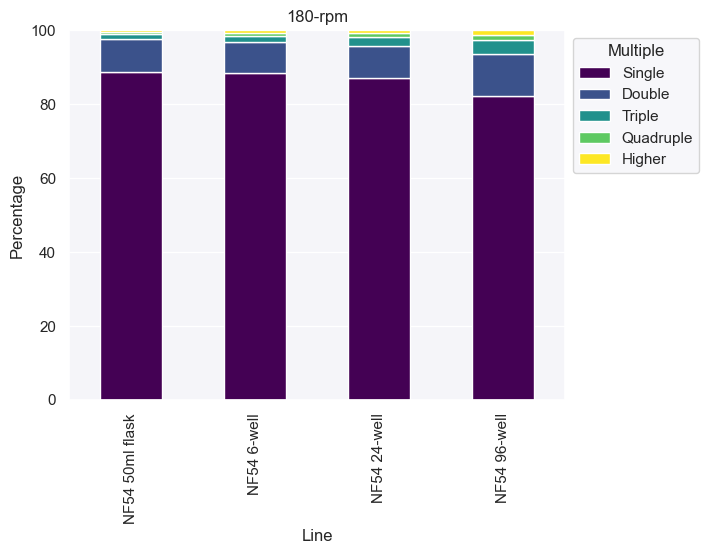

<Figure size 9000x7200 with 0 Axes>

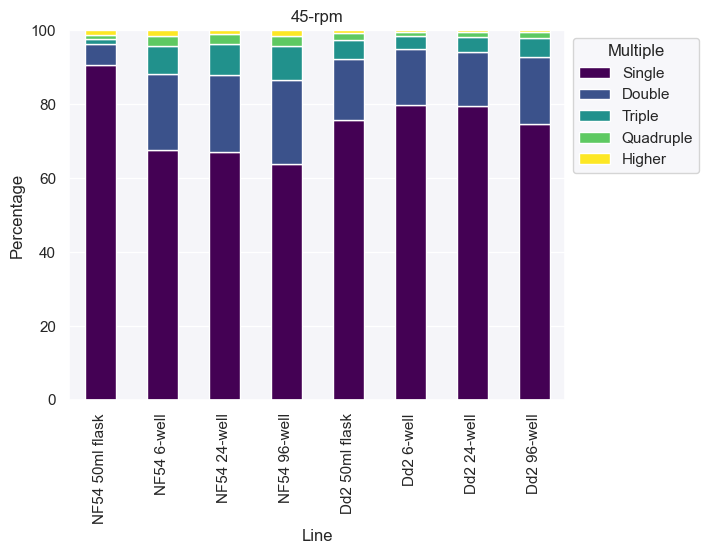

<Figure size 9000x7200 with 0 Axes>

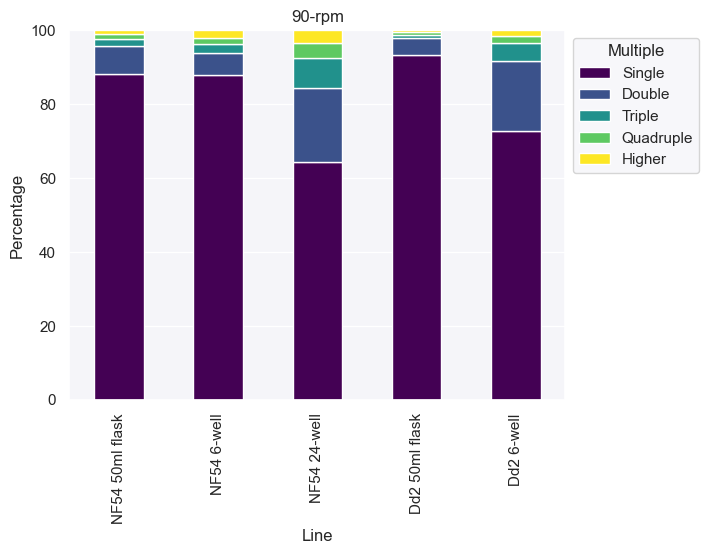

<Figure size 9000x7200 with 0 Axes>

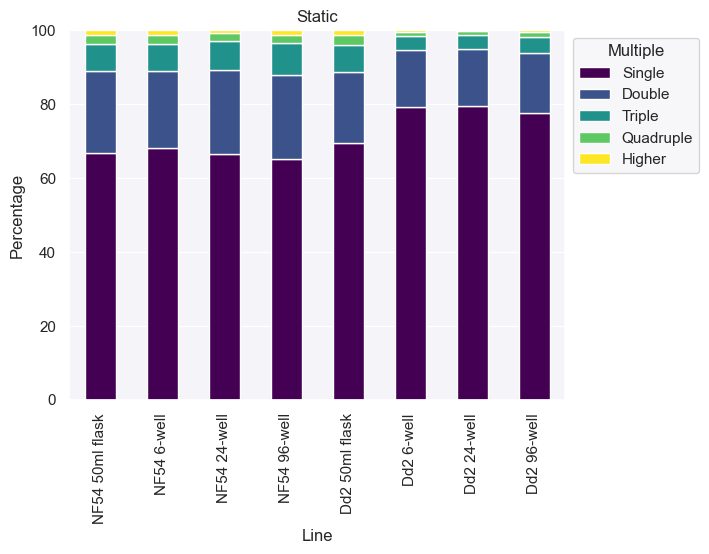

In [9]:
# Create a custom order for the 'Multiple' column
stack_order = ['Single', 'Double', 'Triple', 'Quadruple', 'Higher']
#Static
#strain_order = ['NF54 ', 'KOP230P C3 ','KOP230P C5 ', 'KOPfs25 C1 ', 'KOPfs25 C3 ', 'KOEBA140 C3 ','KOEBA140 C4 ', 'KOEBA175 C6 ', 'KOEBA181 C1 ', 'KOEBA181 C2 ', 'KORH1 C1 ' , 'KORH2a C1 ', 'KORH2a C3 ', 'KORH4 C1']
#shaking
#strain_order = ['NF54 ', 'KOP230P C3 ','KOP230P C5 ', 'KOPfs25 C1', 'KOPfs25 C3', 'KOEBA140 C3 ','KOEBA140 C4 ', 'KOEBA175 C6 ', 'KOEBA181 C1 ', 'KOEBA181 C2 ', 'KORH1 C1 ' , 'KORH2a C1', 'KORH2a C3 ', 'KORH4 C1']

sns.set_theme(#context='notebook', 
            #style='ticks', 
            style='darkgrid', 
            font='arial', 
            # font_scale=3.5
            ) 
            #   color_codes=True, 
            #   rc=None)

sns.set_style(rc = {'axes.facecolor': '#F5F5F9'})

def make_invasion_plot(df, label):
    plt.figure(figsize=(30, 24), dpi=300)

    # Create a pivot table to calculate the bottom positions for each 'Multiple' group
    pivot_df = df.pivot_table(index='Line', columns='Multiple', values='Percentage', fill_value=0)
    pivot_df = pivot_df[stack_order]  # Reorder the columns based on stack_order

    # Reorder the rows (strains) based on strain_order
    present_line_order = [l for l in line_order if l in df['Line'].unique()]
    pivot_df = pivot_df.loc[present_line_order]

    # Create the stacked barplot using Seaborn
    ax = pivot_df.plot(kind='bar', stacked=True, cmap='viridis')

    # Customize the plot as needed
    # plt.xlabel('Strain')
    plt.ylabel('Percentage')
    plt.title(f'{speed}')

    # Show the plot
    plt.legend(title='Multiple')
    sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

    plt.ylim((0,100))
    plt.xticks(rotation=90)

    output_folder = f'Multiinvation {experiment}'
    if not os.path.exists(output_folder): os.makedirs(output_folder)
    
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(f'{output_folder}/{label}.svg', bbox_inches='tight')

for speed, dfg in df_melted.groupby('Speed'):
    make_invasion_plot(dfg, label=f'{speed}')

,Well,Line,Speed,Plate,Multiple,Percentage,Strain
0,A1,NF54 6-well,Static,6-well,Double,19.419123,NF54
1,A1,NF54 6-well,Static,6-well,Higher,1.381653,NF54
2,A1,NF54 6-well,Static,6-well,Lates,7.017955,NF54
3,A1,NF54 6-well,Static,6-well,Quadruple,2.520177,NF54
4,A1,NF54 6-well,Static,6-well,Single,69.309722,NF54


<Figure size 3000x7200 with 0 Axes>

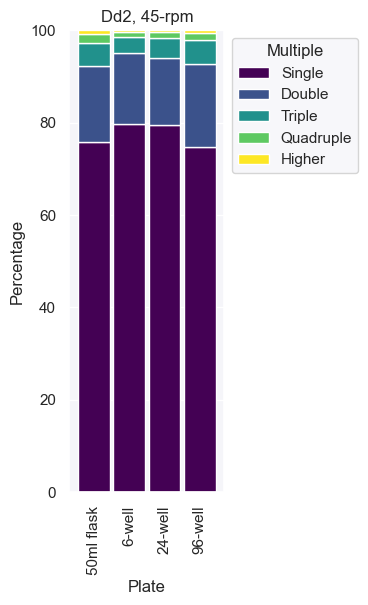

<Figure size 3000x7200 with 0 Axes>

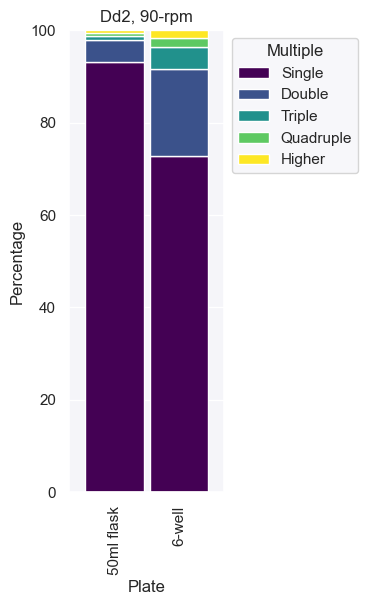

<Figure size 3000x7200 with 0 Axes>

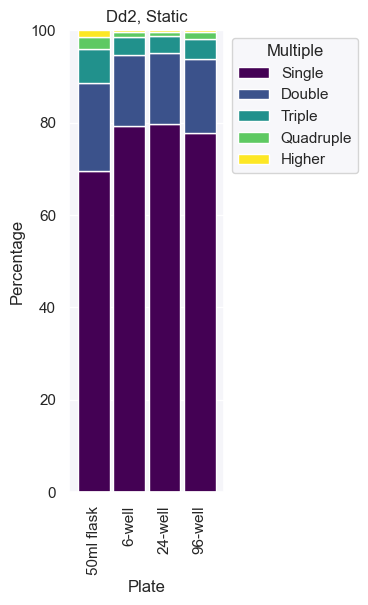

<Figure size 3000x7200 with 0 Axes>

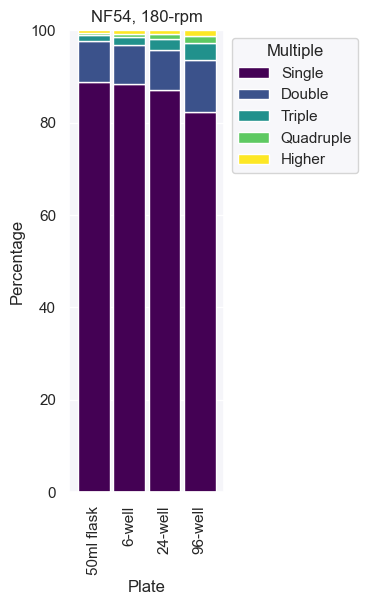

<Figure size 3000x7200 with 0 Axes>

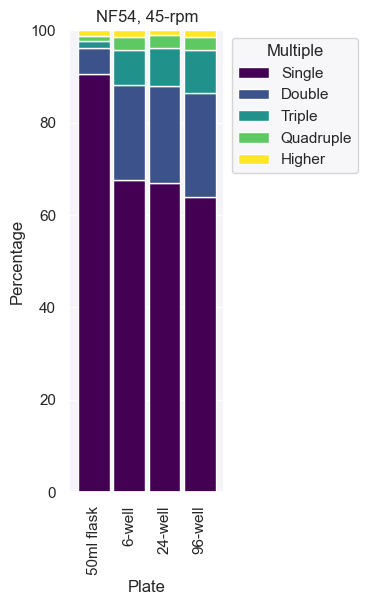

<Figure size 3000x7200 with 0 Axes>

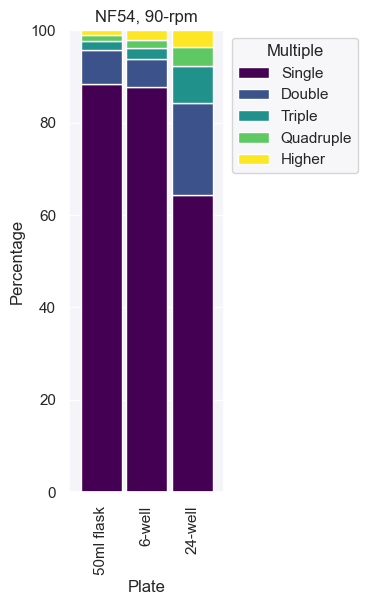

<Figure size 3000x7200 with 0 Axes>

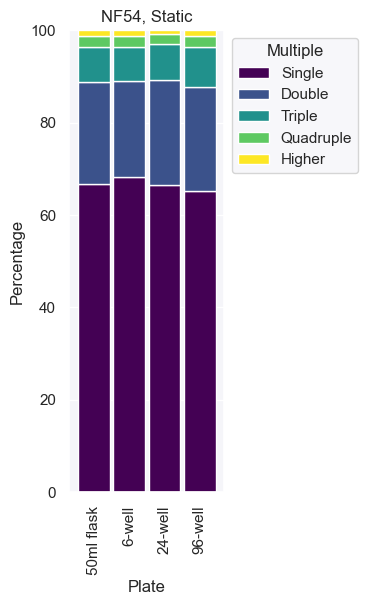

In [29]:
#This only works for GA3 
%matplotlib inline
# Create a custom order for the 'Multiple' column
stack_order = ['Single', 'Double', 'Triple', 'Quadruple', 'Higher']
speed_order = ['Static', '45-rpm', '90-rpm', '180-rpm']
#Static
#strain_order = ['NF54 ', 'KOP230P C3 ','KOP230P C5 ', 'KOPfs25 C1 ', 'KOPfs25 C3 ', 'KOEBA140 C3 ','KOEBA140 C4 ', 'KOEBA175 C6 ', 'KOEBA181 C1 ', 'KOEBA181 C2 ', 'KORH1 C1 ' , 'KORH2a C1 ', 'KORH2a C3 ', 'KORH4 C1']
#shaking
#strain_order = ['NF54 ', 'KOP230P C3 ','KOP230P C5 ', 'KOPfs25 C1', 'KOPfs25 C3', 'KOEBA140 C3 ','KOEBA140 C4 ', 'KOEBA175 C6 ', 'KOEBA181 C1 ', 'KOEBA181 C2 ', 'KORH1 C1 ' , 'KORH2a C1', 'KORH2a C3 ', 'KORH4 C1']

# sns.set_theme(#context='notebook', 
#             #style='ticks', 
#             style='darkgrid', 
#             font='arial', 
#             # font_scale=3.5
#             ) 
#             #   color_codes=True, 
#             #   rc=None)

# sns.set_style(rc = {'axes.facecolor': '#F5F5F9'})

def make_invasion_plot(df, label, xkey = "Plate", order=plate_order):
    plt.figure(figsize=(10, 24), dpi=300)

    # Create a pivot table to calculate the bottom positions for each 'Multiple' group
    pivot_df = df.pivot_table(index=xkey, columns='Multiple', values='Percentage', fill_value=0)
    pivot_df = pivot_df[stack_order]  # Reorder the columns based on stack_order

    # Reorder the rows (strains) based on strain_order
    present_line_order = [l for l in order if l in df[xkey].unique()]
    pivot_df = pivot_df.loc[present_line_order]


    # Create the stacked barplot using Seaborn
    ax = pivot_df.plot(kind='bar', stacked=True, cmap='viridis', width=0.9, figsize=(2,6))
    # sns.barplot(
    #     data=df,
    #     x='Speed',
    #     y='Percentage',
    #     hue='Multiple',
    #     stacked=True,
    # )
    # Customize the plot as needed
    # plt.xlabel('Strain')
    plt.ylabel('Percentage')
    plt.title(label)

    # Show the plot
    plt.legend(title='Multiple')
    sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

    plt.ylim((0,100))
    plt.xticks(rotation=90)

    output_folder = f'Multiinvation {experiment}'
    if not os.path.exists(output_folder): os.makedirs(output_folder)
    
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(f'{output_folder}/{label}.svg', bbox_inches='tight')

df_melted['Strain'] = df_melted['Line'].str.split(' ').str[0]
for (strain, speed), dfg in df_melted.groupby(['Strain', 'Speed']):
    make_invasion_plot(dfg, label=f'{strain}, {speed}')
df_melted.head()

,Well,Line,Speed,Plate,Multiple,Percentage,Strain
0,A1,NF54 6-well,Static,6-well,Double,19.419123,NF54
1,A1,NF54 6-well,Static,6-well,Higher,1.381653,NF54
2,A1,NF54 6-well,Static,6-well,Lates,7.017955,NF54
3,A1,NF54 6-well,Static,6-well,Quadruple,2.520177,NF54
4,A1,NF54 6-well,Static,6-well,Single,69.309722,NF54


<Figure size 3000x7200 with 0 Axes>

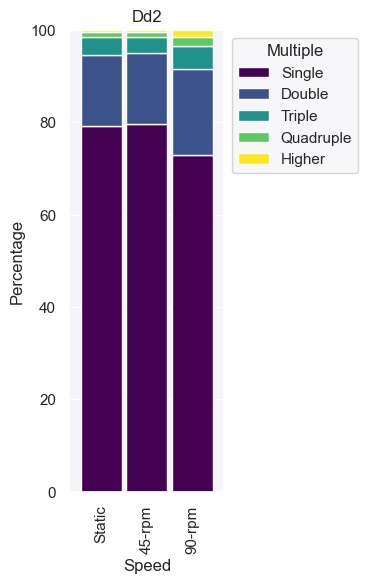

<Figure size 3000x7200 with 0 Axes>

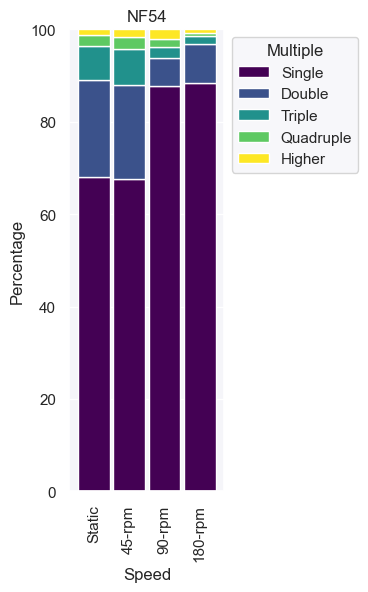

In [30]:
for strain, dfg in df_melted.query('Strain == ["Dd2", "NF54"] and Plate == "6-well"').groupby('Strain'):
    make_invasion_plot(dfg, label=f'{strain}', xkey='Speed', order=speed_order)
df_melted.head()

,Well,Line,Speed,Plate,Multiple,Percentage,Strain
0,A1,NF54 6-well,Static,6-well,Double,19.419123,NF54
1,A1,NF54 6-well,Static,6-well,Higher,1.381653,NF54
2,A1,NF54 6-well,Static,6-well,Lates,7.017955,NF54
3,A1,NF54 6-well,Static,6-well,Quadruple,2.520177,NF54
4,A1,NF54 6-well,Static,6-well,Single,69.309722,NF54


<Figure size 3000x7200 with 0 Axes>

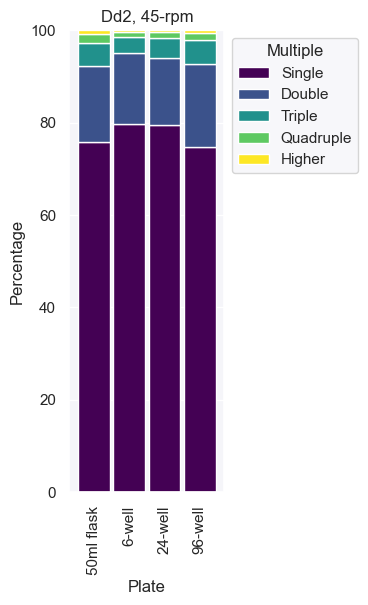

<Figure size 3000x7200 with 0 Axes>

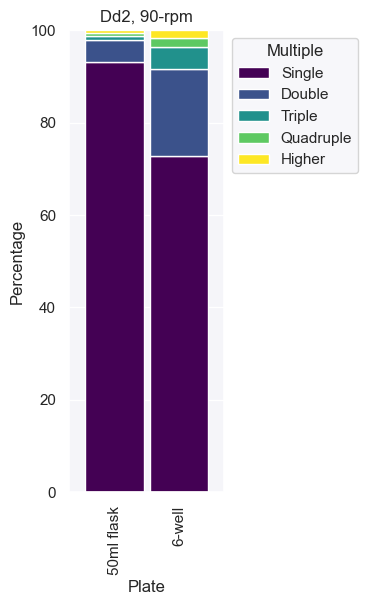

<Figure size 3000x7200 with 0 Axes>

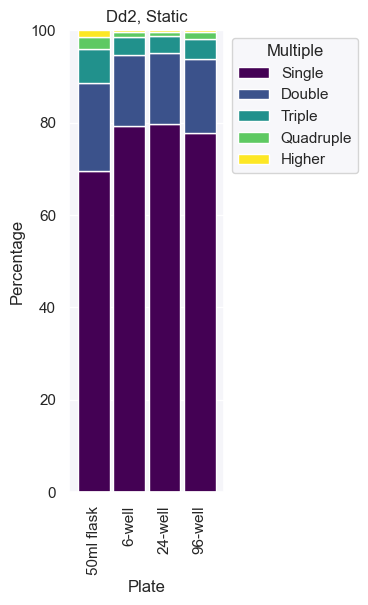

<Figure size 3000x7200 with 0 Axes>

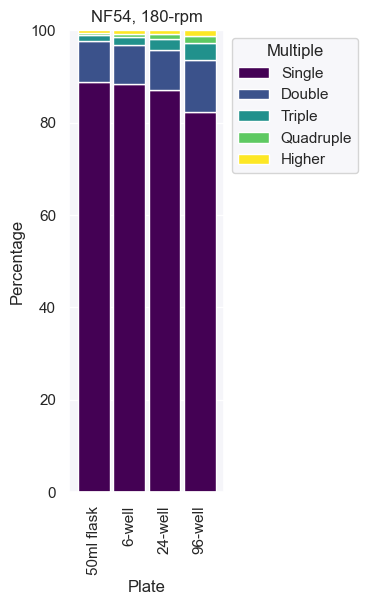

<Figure size 3000x7200 with 0 Axes>

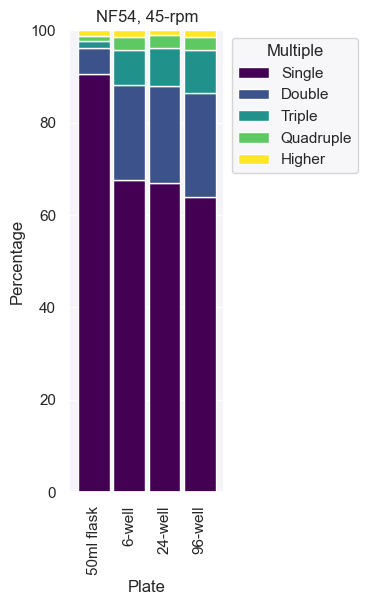

<Figure size 3000x7200 with 0 Axes>

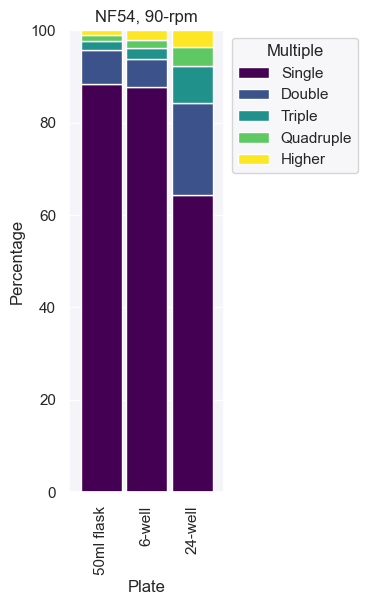

<Figure size 3000x7200 with 0 Axes>

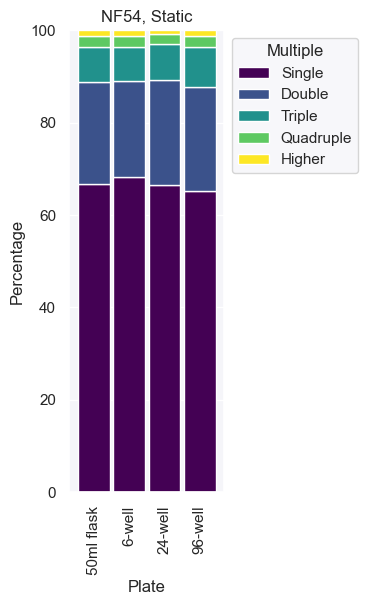

In [ ]:
#GA2 
%matplotlib inline
# Create a custom order for the 'Multiple' column
stack_order = ['Single', 'Double', 'Triple', 'Quadruple', 'Higher']
speed_order = ['Static', '45-rpm', '90-rpm', '180-rpm']
#Static
#strain_order = ['NF54 ', 'KOP230P C3 ','KOP230P C5 ', 'KOPfs25 C1 ', 'KOPfs25 C3 ', 'KOEBA140 C3 ','KOEBA140 C4 ', 'KOEBA175 C6 ', 'KOEBA181 C1 ', 'KOEBA181 C2 ', 'KORH1 C1 ' , 'KORH2a C1 ', 'KORH2a C3 ', 'KORH4 C1']
#shaking
#strain_order = ['NF54 ', 'KOP230P C3 ','KOP230P C5 ', 'KOPfs25 C1', 'KOPfs25 C3', 'KOEBA140 C3 ','KOEBA140 C4 ', 'KOEBA175 C6 ', 'KOEBA181 C1 ', 'KOEBA181 C2 ', 'KORH1 C1 ' , 'KORH2a C1', 'KORH2a C3 ', 'KORH4 C1']

# sns.set_theme(#context='notebook', 
#             #style='ticks', 
#             style='darkgrid', 
#             font='arial', 
#             # font_scale=3.5
#             ) 
#             #   color_codes=True, 
#             #   rc=None)

# sns.set_style(rc = {'axes.facecolor': '#F5F5F9'})

def make_invasion_plot(df, label):
    plt.figure(figsize=(10, 24), dpi=300)

    # Create a pivot table to calculate the bottom positions for each 'Multiple' group
    pivot_df = df.pivot_table(index='Plate', columns='Multiple', values='Percentage', fill_value=0)
    pivot_df = pivot_df[stack_order]  # Reorder the columns based on stack_order

    # Reorder the rows (strains) based on strain_order
    present_line_order = [l for l in plate_order if l in df['Plate'].unique()]
    pivot_df = pivot_df.loc[present_line_order]

    # Create the stacked barplot using Seaborn
    ax = pivot_df.plot(kind='bar', stacked=True, cmap='viridis', width=0.9, figsize=(2,6))
    # sns.barplot(
    #     data=df,
    #     x='Speed',
    #     y='Percentage',
    #     hue='Multiple',
    #     stacked=True,
    # )
    # Customize the plot as needed
    # plt.xlabel('Strain')
    plt.ylabel('Percentage')
    plt.title(label)

    # Show the plot
    plt.legend(title='Multiple')
    sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))

    plt.ylim((0,100))
    plt.xticks(rotation=90)

    output_folder = f'Multiinvation {experiment}'
    if not os.path.exists(output_folder): os.makedirs(output_folder)
    
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(f'{output_folder}/{label}.svg', bbox_inches='tight')

df_melted['Strain'] = df_melted['Line'].str.split(' ').str[0]
for (strain, speed), dfg in df_melted.groupby(['Strain', 'Speed']):
    make_invasion_plot(dfg, label=f'{strain}, {speed}')
df_melted.head()

['Single' 'Double' 'Triple' 'Quadruple' 'Higher' 'Lates']


c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Emma Jones\.conda\envs\py311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

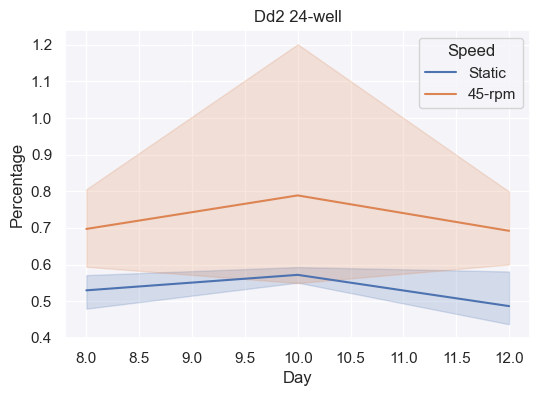

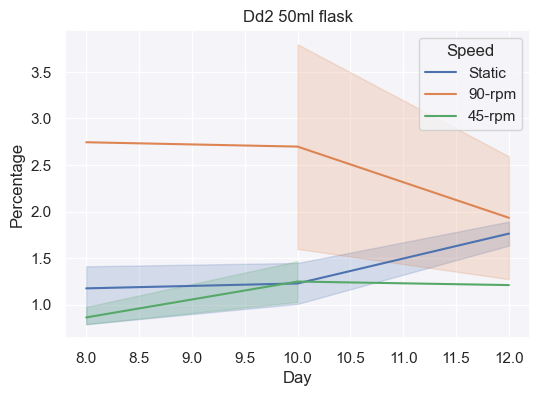

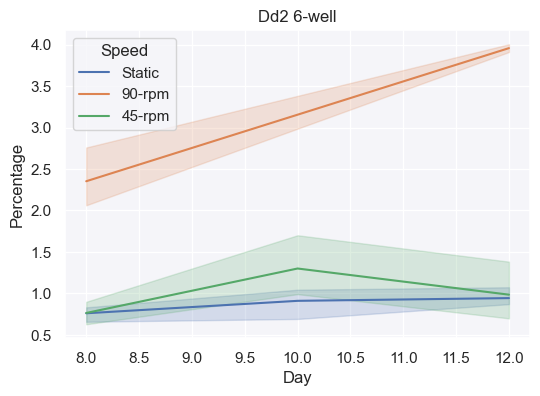

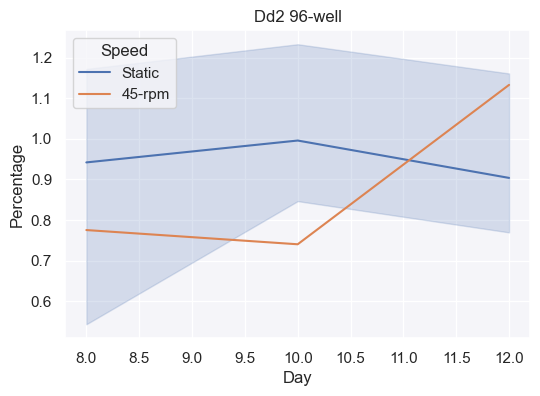

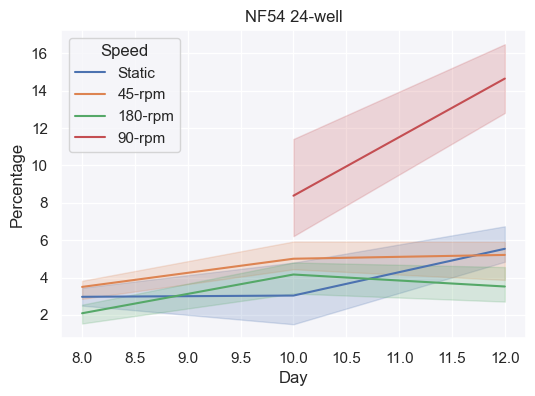

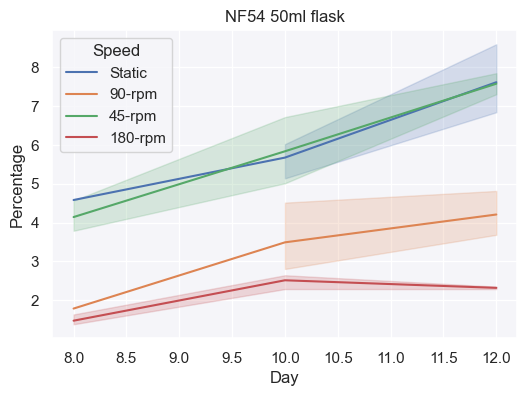

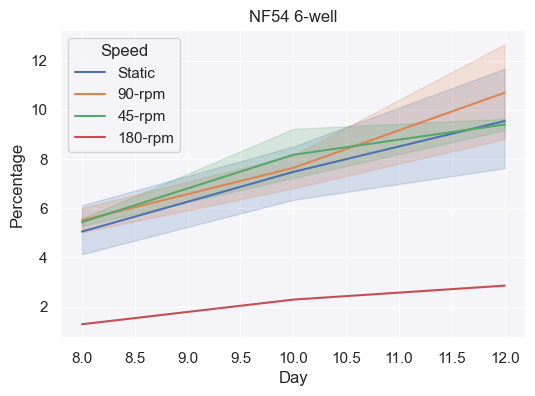

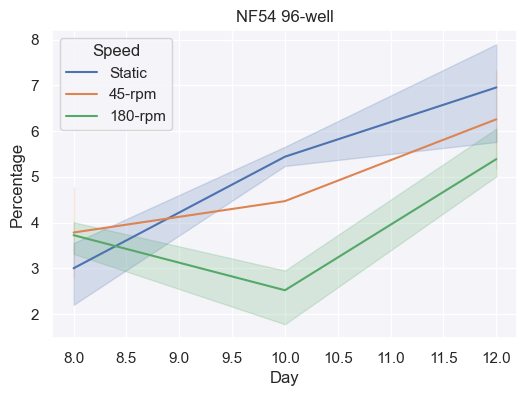

In [ ]:
def plot_lates_per_day(df, label):
    plt.figure(figsize=(6,4), dpi=100)
    sns.lineplot(
        data=df,
        x='Day',
        y='Percentage',
        hue='Speed',
    )
    plt.title(label)

print(df_melted_per_day['Multiple'].unique())

for line, dfg in df_melted_per_day.query('Multiple == "Lates"').groupby('Line'):
    plot_lates_per_day(dfg, line)